In [1]:
import numpy as np
import sklearn
import os
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
import copy

In [2]:
#!pip install line_profiler

In [3]:
os.chdir("/content/drive/MyDrive/Winter_Research")

### Load Data

In [ ]:
master_df = pd.read_csv("Sentinel2_Traffic/Traffic_Data/5_state_traffic.csv")
master_df = master_df.set_index("Unnamed: 0")
CA_x, CA_y = [], []
KS_x, KS_y = [], []
MT_x, MT_y = [], []
TX_x, TX_y = [], []
OH_x, OH_y = [], []
states = {"CA" : [CA_x, CA_y, "Roi_1"],
         "KS" : [KS_x, KS_y, "Roi_2"],
         "MT" : [MT_x, MT_y, "Roi_3"],
         "TX" : [TX_x, TX_y, "Roi_4"],
         "OH" : [OH_x, OH_y, "Roi_5"]}
for st in ["CA", "KS", "MT", "TX", "OH"]:
  path = "Rois/" + states[st][2] + "/greedy_a/"
  imgs = os.listdir(path)
  for img in imgs:
    date = img.split('.')[0]
    photo = np.loadtxt(path + img).reshape(-1, 7, 3)
    if photo[pd.isnull(photo)].shape[0] == 0:
      print("waasss", photo.shape[0])
      if st == "CA" and photo.shape[0] != 72264:
        continue
      if st == "KS" and photo.shape[0] != 69071:
        continue
      if st == "MT" and photo.shape[0] != 72099:
        continue
      if st == "TX" and photo.shape[0] != 71764:
        continue
      if st == "OH" and photo.shape[0] != 62827:
        continue
      if date in list(master_df.index):
        if not pd.isna(master_df.loc[date][st]):
          states[st][0].append(photo)
          states[st][1].append(master_df.loc[date][st])

In [ ]:
len(states['CA'][0])

0

In [22]:
states

{'CA': [[], [], 'Roi_1'],
 'KS': [[], [], 'Roi_2'],
 'MT': [[], [], 'Roi_3'],
 'OH': [[], [], 'Roi_5'],
 'TX': [[], [], 'Roi_4']}

In [18]:
for s in ["CA", "KS", "MT", "TX", "OH"]:
  for i in range(len(states[s][0])): 
    states[s][0][i] = states[s][0][i][:8955]

In [9]:
def load(states, mean_bal_x=True, mean_bal_y=True):
  img_st = []
  y = []
  for s in states:
    val = np.array(states[s][0])
    if mean_bal_x:
      img_st.append((val - np.mean(val, axis=0)) / np.mean(val, axis=0))
    else:
      img_st.append(val)
    for i in states[s][1]:
      if mean_bal_y:
        y.append((i - np.mean(states[s][1])) / np.mean(states[s][1]))
      else:
        y.append(i)
  X = np.concatenate(img_st)
  return X, y

In [10]:
X, y = load(states, mean_bal_x=False, mean_bal_y=False)

In [21]:
print(len(X), len(y))

0 0


In [ ]:
def load_some(states):
  img_st = []
  y = []
  for s in states:
    if s == "MT":
      continue
    img_st.append(np.array(states[s][0]))
    for i in states[s][1]:
      y.append(i)
  X = np.concatenate(img_st)
  return np.array(X), np.array(y)

def load_MT(states):
  img_st = np.array(states["MT"][0])
  y_test = []
  for i in states["MT"][1]:
    y_test.append(i)
  return img_st, np.array(y_test)

def load_some_augment(X, y):
  new_imgs = []
  new_y = []
  for i in range(X.shape[0]):
    a = random.randint(0, X.shape[0] - 1)
    b = random.randint(0, X.shape[0] - 1)
    new_imgs.append(mush(X[a], X[b]))
    new_y.append(y[a] + y[b])
  return np.array(new_imgs), np.array(new_y)

def mush(img_a, img_b):
  new_img = np.zeros((img_a.shape[0] + img_b.shape[0], 7, 3))
  buffer = int((img_a.shape[0] + 0.5) // 8)
  # print(buffer)
  for i in range(0, img_a.shape[0]*2, buffer*2):
    # print(i)
    # print(img_a[i // 2: i // 2 + buffer, :, :].shape)
    if (i // 2) + buffer > img_a.shape[0]:
      buffer = img_a.shape[0] - (i // 2)
    new_img[i: i + buffer, :, :] = img_a[i // 2: i // 2 + buffer, :, :]
    new_img[i + buffer: i + 2 * buffer, :, :] = img_b[i // 2: i // 2 + buffer, :, :]
  return new_img 

In [ ]:
#X, y = load_some_augment(X, y)
# X_test, y_test = load_MT(states)
# X_test, y_test = augment(X_test)

In [ ]:
# y_test

In [ ]:
# X_test = np.concatenate((X_test, X_test), axis=1)
# y_test = y_test + y_test

In [14]:
def augment(X, y):
  new_imgs = []
  new_y = []
  for i in range(X.shape[0]):
    new_y.extend([y[i]]*4)
    #OG
    #new_imgs.append(X[i]) #1
    #Chunk Half 
    chunk1 = X[i][:X[i].shape[0] // 3, :, :]
    chunk2 = X[i][X[i].shape[0] // 3 : 2 * X[i].shape[0] // 3, :, :]
    chunk3 = X[i][2 * X[i].shape[0] // 3 :, :, :]
    chunks = {0 : chunk1, 1 : chunk2, 2 : chunk3}
    # for order in [(0, 1, 2), (0, 2, 1)]: #, (1, 0, 2), (1, 2, 0), (2, 1, 0), (2, 0, 1)
      # new_img = np.zeros(X[i].shape)
      # new_img[:X[i].shape[0] // 3, :, :] = chunks[order[0]]
      # new_img[X[i].shape[0] // 3 : 2 * X[i].shape[0] // 3, :, :] = chunks[order[1]]
      # new_img[2 * X[i].shape[0] // 3 :, :, :] = chunks[order[2]]
    new_img = X[i]
    new_imgs.append(new_img) 
    new_imgs.append(np.flip(new_img, axis=0)) 
    new_imgs.append(np.flip(new_img, axis=1)) 
    new_imgs.append(np.flip(np.flip(new_img, axis=0), axis=1)) 
  return np.array(new_imgs), np.array(new_y)



In [ ]:
# Can't sugment befoire split
# X, y = load_some(states)
# X, y = augment(X, y)
# print(X.shape, y.shape)

In [ ]:
# y_baseline = np.loadtxt("Baseline_Y.csv", delimiter=',')

In [12]:
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')


1


In [13]:
#Train, test, val, split
# 41

#Just MT version
X_train_t, X_test, y_train_t, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=41)
# X_train_t = X
# y_train_t = y
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train_t, y_train_t, test_size=0.1, random_state=41)
X_train, y_train = augment(X_train, y_train)
#To tensors
X_train = torch.as_tensor(X_train, device=cuda0, dtype=torch.float)
X_test = torch.as_tensor(X_test, device=cuda0, dtype=torch.float)
X_val = torch.as_tensor(X_val, device=cuda0, dtype=torch.float)
y_train = torch.as_tensor(y_train, device=cuda0, dtype=torch.float)
y_val = torch.as_tensor(y_val, device=cuda0, dtype=torch.float)
y_test = torch.as_tensor(y_test, device=cuda0, dtype=torch.float)

#Reshape y
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

ValueError: ignored

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

torch.Size([388, 8955, 7, 3]) torch.Size([388, 1]) torch.Size([11, 8955, 7, 3]) torch.Size([11, 1]) torch.Size([28, 8955, 7, 3]) torch.Size([28, 1])


In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

# PyTorch Model

In [ ]:
del model

In [ ]:
X_train.shape

torch.Size([388, 3, 8955, 7])

In [ ]:
# OG 3 ==> 10, reg layer, 10 ==> 10, flatten, ==> 100, 100==> 50, 50 ==> 1
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
    self.reg = nn.BatchNorm2d(10)
    self.relu1 = nn.ReLU()

    #self.reg = nn.Dropout(p=0.8)

    self.conv2 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=3, stride=1, padding=1)
    # self.reg = nn.BatchNorm2d(3)
    self.relu2 = nn.ReLU()

    # self.pool = nn.MaxPool2d(kernel_size=2)

    # self.conv3 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3, stride=1, padding=1)
    # self.reg = nn.BatchNorm2d(10)
    # self.relu3 = nn.ReLU()

    # self.conv4 = nn.Conv2d(in_channels=50, out_channels=10, kernel_size=3, stride=1, padding=1)
    # self.relu4 = nn.ReLU()

    # self.conv5 = nn.Conv2d(in_channels=10, out_channels=100, kernel_size=3, stride=1, padding=1)
    # self.relu5 = nn.ReLU()

    self.fc1 = nn.Linear(in_features=(125370 // 2)*3, out_features=100) # 100
    self.relu6 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=100, out_features=50) #100 -> 50
    self.relu7 = nn.ReLU()
    self.fc3 = nn.Linear(in_features=50, out_features=1)

    # self.relu8 = nn.ReLU()
    # self.fc4 = nn.Linear(in_features=20, out_features=1)

  def forward(self, input):
    output = self.conv1(input)
    output = self.relu1(output)
    output = self.reg(output)
    output = self.conv2(output)
    output = self.relu2(output)
    # output = self.conv3(output)
    # output = self.relu3(output)

    # output = self.pool(output)

    # output = self.conv3(output)
    # output = self.relu3(output)

    # output = self.conv4(output)
    # output = self.relu4(output)

    # output = self.conv4(output)
    # output = self.relu4(output)
    #print(output.shape)
    output = output.reshape(-1, (125370 // 2)*3)
    #print(output.shape)
    output = self.fc1(output)
    output = self.relu6(output)
    #print(output.shape)
    output = self.fc2(output)
    output = self.relu7(output)
    output = self.fc3(output)
    # output = self.relu8(output)
    # output = self.fc4(output)
    #print(output.shape)

    return output
model = Net()
model = model.cuda()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
X_train.shape

torch.Size([388, 3, 8955, 7])

In [ ]:
batches_x = []
batches_y = []
batch_size = 10
for i in range(0, X_train.shape[0], batch_size):
  batches_x.append(X_train[i:i+batch_size])
  batches_y.append(y_train[i:i+batch_size])

In [ ]:
batches_x[0].shape

torch.Size([10, 3, 8955, 7])

In [ ]:
del optimizer
del criterion
# del model
torch.cuda.empty_cache()


In [ ]:
criterion = nn.MSELoss()
model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_loss = []
val_loss = []

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (reg): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(10, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=188055, out_features=100, bias=True)
  (relu6): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu7): ReLU()
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
best_model = model
min_val = 1e9
loss_arr = []

In [ ]:
epochs = 100
for i in range(epochs):
  model.train()
  loss_tot = 0
  #for j in range(X_train.shape[0]):
  for batch_x, batch_y in zip(batches_x, batches_y):
    # print(batch_x.shape)  
    y_hat = model.forward(batch_x)
  #print("y_hat", y_hat.shape, y_hat)
  #print("y_train", y_train)
  #break
    loss = criterion(y_hat, batch_y)
    loss_arr.append(loss)
    loss_tot += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    model.eval()
    y_hat_t = model.forward(X_val)
    loss_v = criterion(y_hat_t, y_val)
    val_loss.append(loss_v.item())
    if loss_v.item() < min_val:
      print("new_best")
      min_val = loss_v.item()
      best_model = copy.deepcopy(model)
  if i % 5 == 0:
    print(f'Epoch: {i} Train Loss: {loss_tot // len(batches_x)} " Val Loss: "{loss_v}')
    train_loss.append(int(loss_tot // len(batches_x)))

new_best
Epoch: 0 Train Loss: 899817.0 " Val Loss: "317474.84375
new_best
new_best
Epoch: 5 Train Loss: 170998.0 " Val Loss: "288390.6875
Epoch: 10 Train Loss: 128396.0 " Val Loss: "520420.0
new_best
Epoch: 15 Train Loss: 65450.0 " Val Loss: "218221.875
Epoch: 20 Train Loss: 46558.0 " Val Loss: "352452.9375
Epoch: 25 Train Loss: 69562.0 " Val Loss: "362639.8125
Epoch: 30 Train Loss: 46411.0 " Val Loss: "475999.0625
Epoch: 35 Train Loss: 46289.0 " Val Loss: "825221.125
Epoch: 40 Train Loss: 58508.0 " Val Loss: "446751.1875
new_best
Epoch: 45 Train Loss: 39377.0 " Val Loss: "651930.9375
Epoch: 50 Train Loss: 12022.0 " Val Loss: "498406.84375
Epoch: 55 Train Loss: 44375.0 " Val Loss: "211176.53125
Epoch: 60 Train Loss: 64846.0 " Val Loss: "553969.25
Epoch: 65 Train Loss: 30397.0 " Val Loss: "248549.21875
Epoch: 70 Train Loss: 34162.0 " Val Loss: "327053.78125
Epoch: 75 Train Loss: 23672.0 " Val Loss: "257724.6875
Epoch: 80 Train Loss: 19590.0 " Val Loss: "229130.6875
Epoch: 85 Train Loss:

In [ ]:
min_val

187721.78125

In [ ]:
preds = []
model.eval()
with torch.no_grad():
  y_hat_t = best_model.forward(X_test)
  loss = criterion(y_hat_t, y_test)
  val_loss.append(loss.item())
  print(loss.item())
  #preds.append(y_hat.argmax().item())

219568.046875


In [ ]:
PATH = "models/augmented_test_115k.tar"
torch.save(model.state_dict(), PATH)

In [ ]:
print(y_test)

In [ ]:
plt.plot(range(len(train_loss[10:])), train_loss[4:])
plt.plot(range(len(val_loss[4:])), val_loss[4:])
plt.legend(["Train Loss", "Val Loss"])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
#plt.savefig("Train_Test.png")
plt.show()

0.8542176643491934


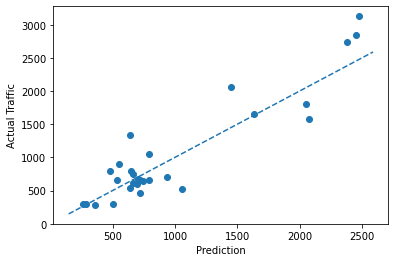

In [ ]:
x_temp = y_test.cpu()
y_temp = y_hat_t.cpu()
# print(y_temp)
# for i in range(y_temp.shape[0]):
#   if y_temp[i] > 5000:
#     print(x_temp.shape)
#     x_temp = torch.cat([x_temp[0:i, :], x_temp[i+1:, :]])
#     y_temp = torch.cat([y_temp[0:i, :], y_temp[i+1:, :]])
#     break
x_plot = np.array(y_temp)
y_plot = np.array(x_temp)
new_x = np.array(x_plot).reshape(-1,1)
new_y = np.array(y_plot)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)
plt.xlabel("Prediction")
plt.ylabel("Actual Traffic")
print(score)
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')
# plt.savefig("Aug_batch_r2_0.85_mse_97k.png")
plt.show()

0.8731882702459102 MSE--123


0.8591212743652898

0.8662367216836014

0.873

0.889 MSE-99

R^2 = 0.911 MSE == 79 num 4

num 5 R^2 0.922 MSE == 82,000

num 11 R^2 == 0.93 MSE = 60

In [ ]:
# 0.945, 0.830
# MSE 88, 914, 76

#0.950
#MSE 63,443

In [ ]:
X_test

In [ ]:
y_hat

In [ ]:
torch.cuda.memory_summary(device=0, abbreviated=False)

In [ ]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

In [ ]:
s = y_train[y_train[:, 1] == 5]

In [ ]:
s

In [ ]:
np.mean(s[:, 0])

477.6363636363636

In [ ]:
preds = {}
for i in range(1, 6):
  select = y_train[y_train[:, 1] == i]
  preds[i] = np.mean(select[:, 0])

In [ ]:
preds

{1: 2504.5172413793102,
 2: 772.2962962962963,
 3: 306.4375,
 4: 732.2631578947369,
 5: 461.7142857142857}

In [ ]:
y_test

In [ ]:
x = []
y = []
mse = 0
for i in range(y_test.shape[0]):
  x.append(preds[y_test[i][1]])
  y.append(y_test[i][0])
  mse += (preds[y_test[i][1]] - y_test[i][0])**2

In [ ]:
mse / len(y_test)

99098.89435494575

0.8734442268681637


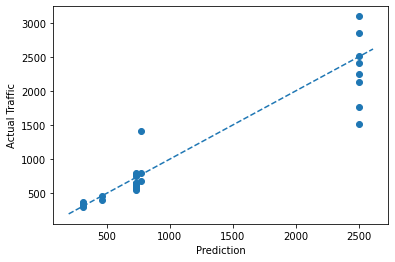

In [ ]:
x_plot = np.array(x)
y_plot = np.array(y)
new_x = np.array(x_plot).reshape(-1,1)
new_y = np.array(y_plot)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)
plt.xlabel("Prediction")
plt.ylabel("Actual Traffic")
print(score)
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')
plt.savefig("Baseline.png")
plt.show()

In [ ]:
# 0.873
# 99098